# Fitting of Molecular Electron Densities. 

This example will showcase how to fit a linear combination of Gaussian functions (e.g. $e^{-\alpha (x^2 + y^2 + z^2) }$ or $(x^2 + y^2 + z^2) e^{-\alpha (x^2 + y^2 + z^2) }$) to a three-dimensional probability distribution $\rho(x, y, z) : \mathbb{R}^3 \rightarrow \mathbb{R}.$

In particular, $\rho$ will be the electron density function of water ($H_2O$) obtained from using the python package chemtools on a Gaussian format checkpoint (fchk) file.

This algorithm will optimize the Kullback-Leibler formula $K(\rho, \tilde{\rho})$ to find the best Gaussian density model $\tilde{\rho}(x, y, z)$ that approximates $\rho$.
In other words,

$$\arg\min_{\tilde{\rho}}  K(\tilde{\rho}, \rho) = \arg\min_{\tilde{\rho}}  \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \rho(x, y, z) \log\bigg(\frac{\rho(x, y, z)}{\tilde{\rho}(x, y, z)} \bigg) dx dy dz $$

### Model
The Gaussian density model of $N$ atoms is built from linear combination of S-type and P-type orbitals centered at each 
nucleus $(x_i, y_i, z_i)$ of that atom. In other words,

$$\tilde{\rho}(r) = \sum_{j=1}^{N} \sum_i c_{ij} \bigg(\frac{\alpha_{ij}}{\pi}\bigg)^{\frac{3}{2}} e^{-\alpha_{ij} r_i^2} + \sum_{j=1}^N \sum_k d_{ik} \bigg(\frac{3\pi^{1.5}}{2 \beta_{ik}^{2.5}}\bigg)r_i^2 e^{-\beta_{ik} r_i^2},$$

where $r_i$ is the radius from the point to the nucleus/atomic center (ie $r_i = \sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}$) and the coefficients
sum to the number of electrons $N_{elec}$. In other words, $ \sum c_i + \sum d_i = N_{elec}$. 

## 1. Specify the Grid.

The first step is to specify a grid on which the probability distribution $\rho$ will be defined on. Here, a Becke-Levedev grid is constructed from the Python package [Grid](https://github.com/theochem/grid) that is specfic to the molecule. This information about the molecule is inside a format checkpoint file which is parsed and loaded by the Python package [IOData](https://github.com/theochem/iodata).

In [1]:
import numpy as np
from iodata import load_one

from grid.becke import BeckeWeights
from grid.molgrid import MolGrid
from grid.onedgrid import GaussChebyshevType2
from grid.rtransform import BeckeTF

# Use IOData to load the molecule and its information
mol = load_one(r"../bfit/data/neutral/h2o_ub3lyp_6311g.fchk")

# Construct a Becke-Levedev grid with 100 radial points.
becke = BeckeWeights(order=3)
oned = GaussChebyshevType2(100)  # Number radial points
rgrid = BeckeTF(1e-4, 5).transform_1d_grid(oned)  # BeckeTF(rmin, rmax)
grid = MolGrid.from_size(mol.atnums, mol.atcoords, rgrid, 500, becke, rotate=False)  # Number of angular points

## 2. Obtain the Molecular Density.

We will now need to evaluate values of the electron density $\rho(x, y, z)$ of water on the Becke-Levedev grid defined above.

This will be done using [Gbasis](https://github.com/theochem/gbasis). The format checkpoint file "h20_ub3lyp_6311g.fchk" of water is located "./bfit/data/neutral/". Using the grid, we will integrate the density to make sure it matches the sum of atomic numbers of each element in water.

In [2]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_density

# Load Contraction Shells and evaluate electron density.
basis, coord_types = from_iodata(mol)
density = evaluate_density(mol.one_rdms["scf"], basis, grid.points, coord_type=coord_types)

# The integration of electron density of water should match the sum of atomic numbers.
print("The integration of electron density is: ", grid.integrate(density))

The integration of electron density is:  9.999999881352602


## 3. Define the Model.

The next step is to define what kind of Gaussian model to place onto each atom in the molecule.

For example, we place a model on the atom $A$ centered at $R_A$ to be composed of 7 $s$-type normalized Gaussians and 3 $p$-type normalized Gaussians : $$\rho_A(x, y, z) = \sum_{i=1}^7 c_i \bigg(\frac{\alpha_i}{\pi} \bigg)^{3/2} e^{-\alpha_i ||(x, y, z) - R_A||^2} + \sum_{j=1}^{3} d_i \bigg(\frac{2\beta_i^{\frac{5}{2}}}{3 \pi^{\frac{3}{2}}} \bigg)  ||(x, y, z)||^2 e^{-\beta_i ||(x, y, z) - R_A||^2}$$

Since oxygen has a higher atomic number, we will assign more basis-functions to it.
In this example, we will place 7 $s$-Type and 3 $p$-Type Gaussian functions to Oxygen and 3 $s$-type Gaussian functions to each Hydrogen.

In [3]:
from bfit.model import MolecularGaussianDensity

# Here, we will defined how many [S-type, P-type] basis functions
# we want for oxygen, hydrogen and other hydrogen.
numb_basis = np.array([[7, 3], [3, 0], [3, 0]])

model = MolecularGaussianDensity(grid.points, mol.atcoords, numb_basis, normalize=True)

## 4. Run the Kullback-Leibler SCF method. 

The final step is to optimize the Kullback-Leibler using the SCF method.

In order to do so, we will first need to define initial guesses for both coefficients $\{c_i\}, \{d_i\}$ and exponents $\{\alpha_i\}, \{\beta_i\}$ of our Gaussian model above.

The recommendation for initial guess are:
    - Initial coefficients does not matter.
    - Exponents even-tempered and spread out.
    
This example will run only 15 iterations for simplicity and will display the output and errors.

The four performance measures are: the integration value over the grid $\int \tilde{\rho}(x, y, z) dx dy dz$, the $L_1(\tilde{\rho}, \rho)$ distance, the $L_\infty(\tilde{\rho}, \rho)$ distance and the Kullback-Leibler $K(\tilde{\rho}, \rho)$. The $L_1$ and $L_\infty$ distance are defined as:

$$L_1(\tilde{\rho}, \rho) = \int |\rho(x, y, z) - \tilde{\rho}(x, y, z)|dx dy dz$$

$$ L_\infty(\tilde{\rho}, \rho) = \max_{(x, y, z)} |\rho(x, y, z) - \tilde{\rho}(x, y, z)|$$

In [4]:
from bfit.fit import KLDivergenceFPI

# Create the fit object.
fit = KLDivergenceFPI(grid, density, model)

# Define coefficients to be all ones for oxygen, hydrogen and hydrogen.
c_o, c_h1, c_h2 = [1.] * 10, [1.] * 3,[1.] * 3
e_o = [0.001, 0.1, 1., 10., 100., 1000., 2000., 0.01, 1., 10.]
e_h1, e_h2 = [0.01, 10., 100.], [0.01, 10., 100.]

# Place all coefficients and exponents in a one-dimensional array
# with the same ordering.
coeffs_h2o = np.array(c_o + c_h1  + c_h2)
exps_h2o = np.array(e_o + c_h1 + c_h2)

# Run the algorithm.
results = fit.run(coeffs_h2o, exps_h2o, maxiter=15, c_threshold=1e-3,
                  e_threshold=1e-4, d_threshold=1e-6, disp=True)


-------------------------------------------------------------------------------------------------------------------------------------------
|Iteration |Integration |      L1       |  L Infinity   | Least-squares |Kullback-Leibler| Change Coeffs |  Change Exps  |Change Objective|
-------------------------------------------------------------------------------------------------------------------------------------------
|    1     | 10.000000  | 3.404213e+00  |  308.718174   | 1.068795e+01  |  8.660143e-01  | 9.983781e-01  | 9.219706e+02  |      inf      |
|    2     | 10.000000  | 2.154237e+00  |   92.918469   | 1.955089e+00  |  3.892675e-01  | 4.493435e-01  | 1.651891e+02  | 4.767468e-01  |
|    3     | 10.000000  | 1.569733e+00  |   41.615902   | 6.344140e-01  |  2.317056e-01  | 2.077806e-01  | 6.959799e+01  | 1.575619e-01  |
|    4     | 10.000000  | 1.300878e+00  |   20.796842   | 2.837115e-01  |  1.663654e-01  | 1.021564e-01  | 3.639257e+01  | 6.534014e-02  |
|    5     | 10.000000  

### Plotting The Error Measures

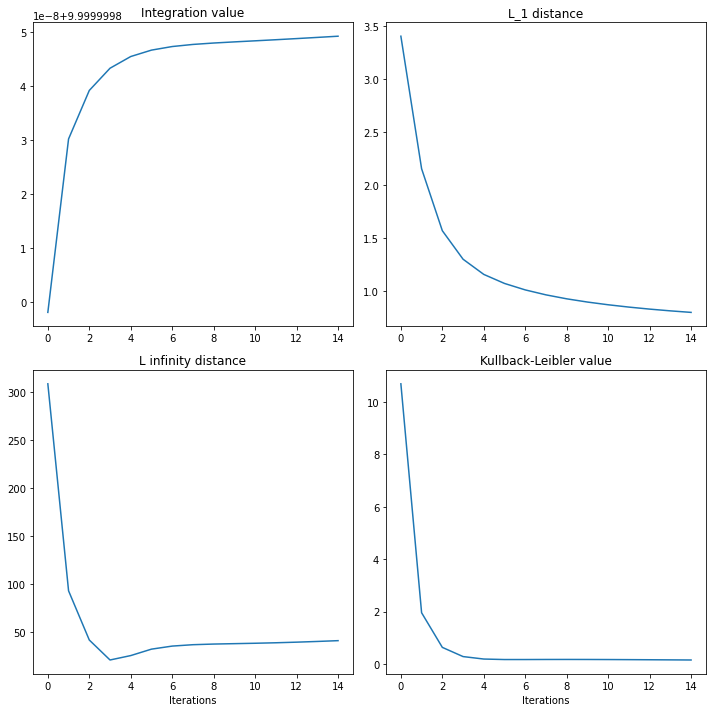

In [7]:
# Plot the error measures.
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(results["performance"][:, 0])
axs[0, 0].set_title("Integration value")
axs[0, 1].plot(results["performance"][:, 1])
axs[0, 1].set_title("L_1 distance")
axs[1, 0].plot(results["performance"][:, 2])
axs[1, 0].set_title("L infinity distance")
axs[1, 1].plot(results["performance"][:, 3])
axs[1, 1].set_title("Kullback-Leibler value")
for ax in fig.get_axes()[2:]:
    ax.set(xlabel='Iterations')
plt.tight_layout()
plt.show()